## Time Series Forecasting using LSTM

___
### Importing necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn import MSELoss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking


class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=150):
        # Perform the custom transformation
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length=window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        # Return the number of trajectories
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the trajectory at the given index
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        num_rows, num_cols = dataframe_array.shape
        window_length += 1  # get one more column as target

        # Preallocate memory for the slices
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)
        
        # Reshape into a flat 2D array for DataFrame-like output
        sliced_data = sliced_data.reshape(-1, window_length)

        return sliced_data
    

### LSTM(Long Short-Term Memory) Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

___
### Importing Data

In [2]:
import os

train_path = os.path.join("/kaggle/input/cse-575-project-2/train.csv")
val_path = os.path.join("/kaggle/input/cse-575-project-2/val.csv")
test_path = os.path.join("/kaggle/input/cse-575-project-2/test.csv")

train_df = pd.read_csv(train_path, header = 0).drop('ids', axis=1)
val_df = pd.read_csv(val_path, header = 0).drop('ids', axis=1)
test_df = pd.read_csv(test_path, header = 0).drop('ids', axis=1)

___
### Training Loop

In [3]:
# Check if MPS is available and set the device accordingly
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")

window_length = 150  # window length

dataset = TrajectoryDataset(dataframe=train_df, window_length=window_length)

batch_size = 64 # batch size

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Model hyperparameters
input_size =  window_length  # Window length
hidden_size = 64
output_size = 1  # Single output for time series forecast (next value)
num_layers = 4
learning_rate = 0.01
num_epochs = 1

# Instantiate the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

criterion = nn.MSELoss() # loss = mean squared error

optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer


# Training loop with tqdm for progress tracking
for epoch in tqdm(range(num_epochs), desc="Epochs"):

    model.train()
    running_loss = 0.0

    for batch_idx, data in enumerate(dataloader):

        # Separate inputs and targets
        inputs = data[:, :-1].to(device)  # Input Features
        targets = data[:, -1].to(device)  # Predicting Last Column (Target)

        inputs = inputs.unsqueeze(1) # adding a new dimension for LSTM

        # parameter gradients -> zero
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass -> update the weights(optimize)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')


# dropout to the LSTM model to reduce overfitting
model.lstm.dropout = 0.3  # 30% dropout

Epochs: 100%|██████████| 1/1 [13:15<00:00, 795.50s/it]

Epoch [1/1], Loss: 0.0003


___
### Evaluation Loop

In [4]:
train_set = torch.tensor(train_df.values[:,:].astype(np.float32), dtype=torch.float32)
val_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)
test_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)

points_to_predict = val_set.shape[1]

# Autoregressive prediction function
def autoregressive_predict(model, input_maxtrix, prediction_length=points_to_predict):
    """
    Perform autoregressive prediction using the learned model.
    
    Args:
    - model: The trained PyTorch model.
    - input_maxtrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.
    
    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    output_matrix = torch.empty(input_maxtrix.shape[0],0)
    current_input = input_maxtrix.unsqueeze(1)
    
    with torch.no_grad():  # No need to calculate gradients for prediction
        for _ in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input)
            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)
            
            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, :, 1:], next_pred.unsqueeze(2)), dim=2)
    
    return output_matrix


initial_input = train_set[:, -window_length:]  #use the last window of training set as initial input
full_trajectories = autoregressive_predict(model, initial_input,)


# Calculate MSE between predicted trajectories and actual validation trajectories using torch
mse_loss = MSELoss()

# Compute MSE
mse = mse_loss(full_trajectories, val_set)

# Print MSE
print(f'Autoregressive Validation MSE (using torch): {mse.item():.4f}')

Autoregressive Validation MSE (using torch): 0.0026


___
### Plotting Trajectory

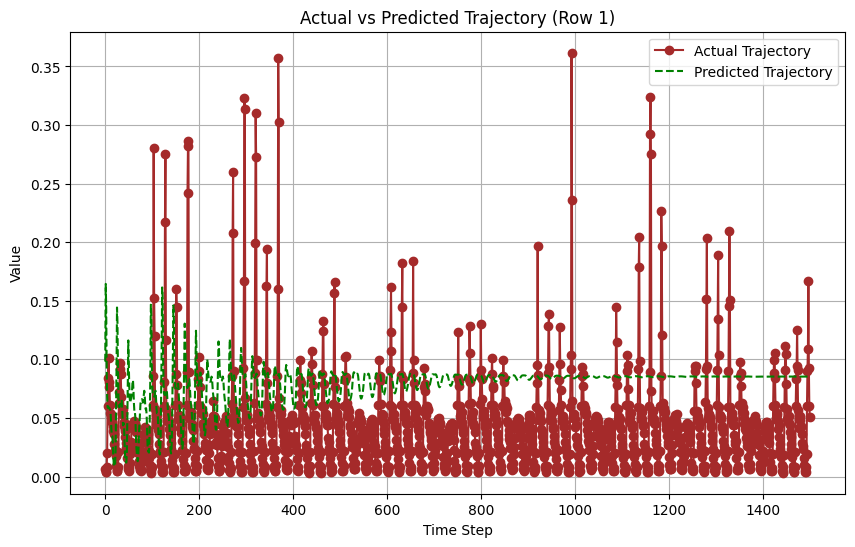

In [5]:
# We can pick a specific row (e.g., row 1) to visualize
row_idx = 1  # You can change this to visualize predictions for different rows
initial_input = val_set[row_idx, :window_length].unsqueeze(0)

# Predict future trajectory of length 100
predicted_trajectory = autoregressive_predict(model, initial_input)

# Get the actual trajectory for comparison
actual_trajectory = val_set[row_idx].numpy()

# Plot the actual vs predicted trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color='brown', marker='o')
plt.plot(range(len(actual_trajectory)), predicted_trajectory.squeeze().numpy(), label="Predicted Trajectory", color='g', linestyle='--')
plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

___
### Predictions for validation and test set

In [6]:
# Generate predictions for all the validation dataset
val_predictions = []
for i in tqdm(range(val_set.shape[0])):
    initial_input = val_set[i, :window_length].unsqueeze(0)
    predicted_trajectory = autoregressive_predict(model, initial_input)
    val_predictions.append(predicted_trajectory.squeeze().numpy())

# Generate predictions for all the testing dataset
test_predictions = []
for i in tqdm(range(test_set.shape[0])):
    initial_input = test_set[i, :window_length].unsqueeze(0)
    predicted_trajectory = autoregressive_predict(model, initial_input)
    test_predictions.append(predicted_trajectory.squeeze().numpy())

# Convert the list of predictions into tensors
val_predictions_tensor = torch.tensor(val_predictions)
test_predictions_tensor = torch.tensor(test_predictions)

# Print their shapes
print(f'Validation Predictions Tensor Shape: {val_predictions_tensor.shape}')
print(f'Test Predictions Tensor Shape: {test_predictions_tensor.shape}')

100%|██████████| 963/963 [19:07<00:00,  1.19s/it]
/tmp/ipykernel_30/1249976236.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  val_predictions_tensor = torch.tensor(val_predictions)


Validation Predictions Tensor Shape: torch.Size([963, 1500])
Test Predictions Tensor Shape: torch.Size([963, 1500])


___
### Generate submission.csv

In [7]:
def generate_submissions_v2(pred_val_tensor, pred_test_tensor, original_val_path, original_test_path):
    # Read the original validation and testing datasets
    original_val_df = pd.read_csv(original_val_path)
    original_test_df = pd.read_csv(original_test_path)

    # Ensure the shape of pred_val_tensor and pred_test_tensor is correct
    assert pred_val_tensor.shape[0] * pred_val_tensor.shape[1] == original_val_df.shape[0] * (original_val_df.shape[1] - 1)
    assert pred_test_tensor.shape[0] * pred_test_tensor.shape[1] == original_test_df.shape[0] * (original_test_df.shape[1] - 1)

    # Create empty lists to store ids and values
    ids = []
    values = []

    # Process validation set
    for col_idx, col in enumerate(original_val_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_val_df[col]):
            ids.append(str(f"{col}_traffic_val_{row_idx}"))
            values.append(float(pred_val_tensor[row_idx, col_idx]))

    # Process testing set
    for col_idx, col in enumerate(original_test_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_test_df[col]):
            ids.append(str(f"{col}_traffic_test_{row_idx}"))
            values.append(float(pred_test_tensor[row_idx, col_idx]))

    # Create the submissions dataframe
    submissions_df = pd.DataFrame({
        "ids": ids,
        "value": values
    })

    # Assert the shape of the dataframe
    assert submissions_df.shape[1] == 2
    assert submissions_df.shape[0] == (original_val_df.shape[0] * (original_val_df.shape[1] - 1)) + (original_test_df.shape[0] * (original_test_df.shape[1] - 1))
    assert "ids" in submissions_df.columns
    assert "value" in submissions_df.columns
    assert submissions_df['value'].isnull().sum() == 0

    # Save to CSV
    submissions_df.to_csv('submission.csv', index=False)

# Call the function
generate_submissions_v2(val_predictions_tensor, test_predictions_tensor, "/kaggle/input/cse-575-project-2/val.csv","/kaggle/input/cse-575-project-2/test.csv")

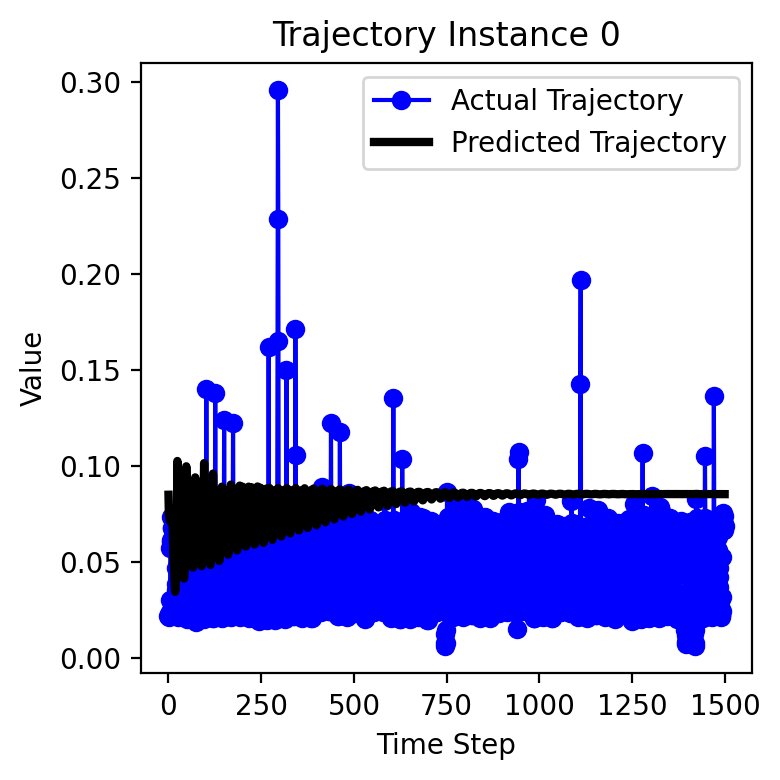

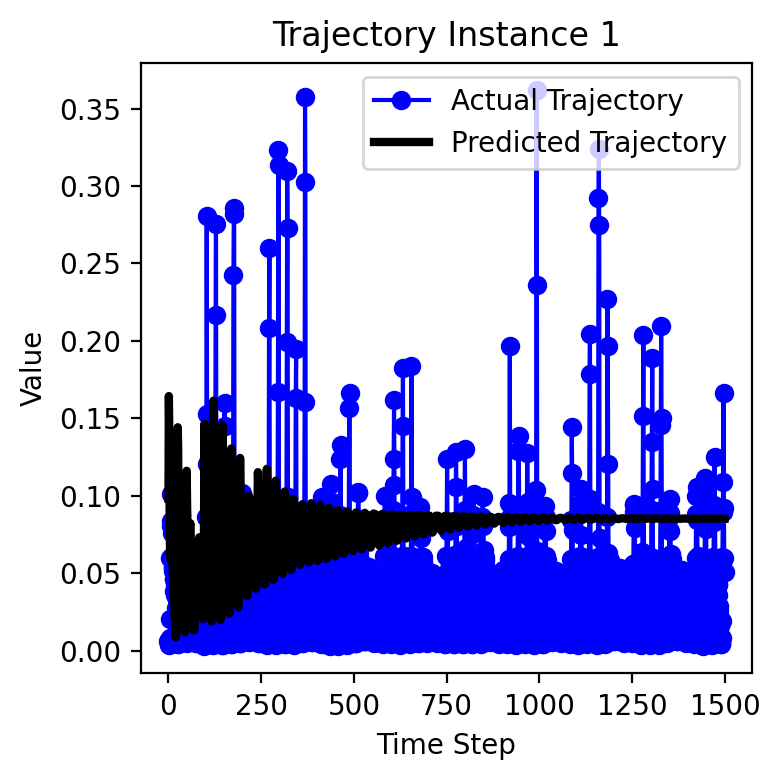

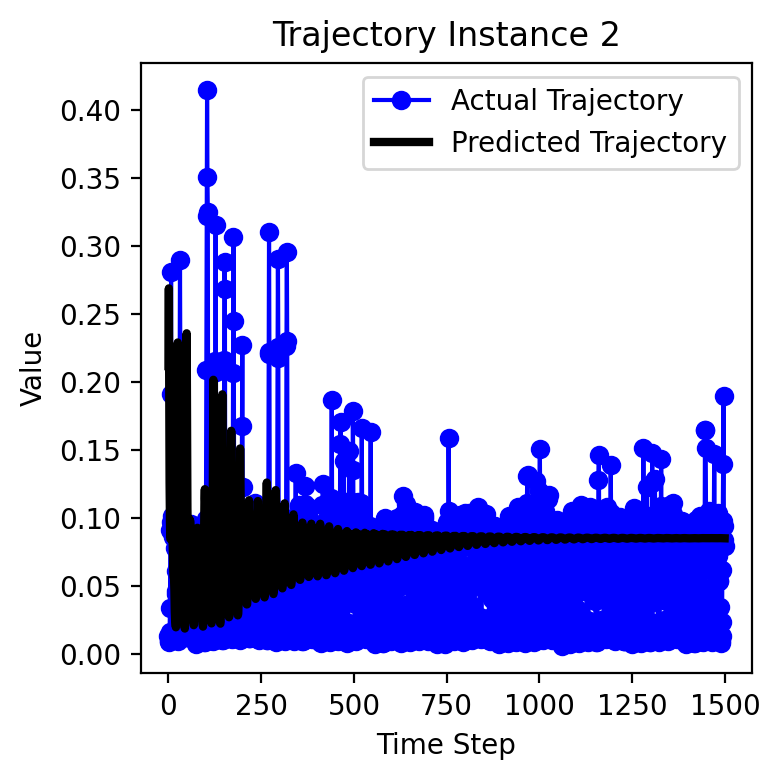

In [8]:
# Generate and save plots for the first three trajectories in the validation set
for row_idx in [0, 1, 2]:
    initial_input = val_set[row_idx, :window_length].unsqueeze(0)
    predicted_trajectory = autoregressive_predict(model, initial_input)
    actual_trajectory = val_set[row_idx].numpy()
    
    plt.figure(figsize=(4, 4), dpi=200)
    plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color='blue', marker='o')
    plt.plot(range(len(actual_trajectory)), predicted_trajectory.squeeze().numpy(), label="Predicted Trajectory", color='black', linestyle='-', linewidth=3)
    plt.title(f"Trajectory Instance {row_idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(f"trajectory_{row_idx}.png", dpi=200)
    plt.show()
    plt.close()